In [2]:
# Extract greyscale, color histograms, colors from image

%matplotlib inline

import argparse
import cv2
import matplotlib.image as mpimg
import matplotlib.pylab as plt
import numpy as np
from skimage import color


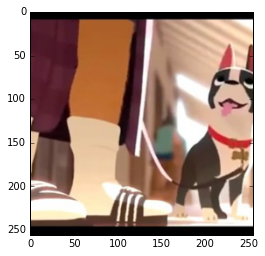

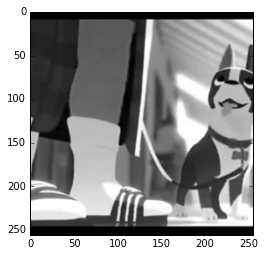

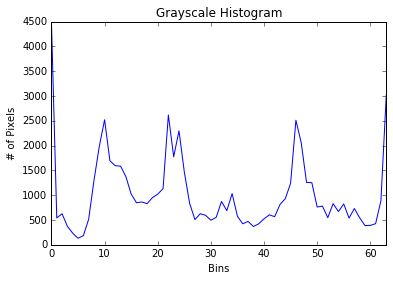

In [21]:
### Grayscale

# Load image
img = mpimg.imread('img.jpg')
imgplot = plt.imshow(img)
plt.show()

# Convert the image to grayscale and create a histogram
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# cv2.imshow('gray', gray)   using plt so it displays inline
plt.imshow(gray, cmap=plt.cm.gray)
plt.show()

# Calculate grayscale histogram
bins = 64
hist = cv2.calcHist([gray], [0], None, [bins], [0, 256])
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
plt.plot(hist)
plt.xlim([0, bins-1])
plt.show()

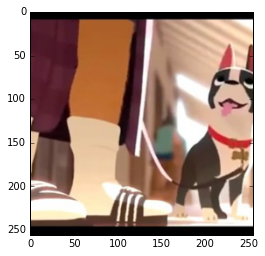

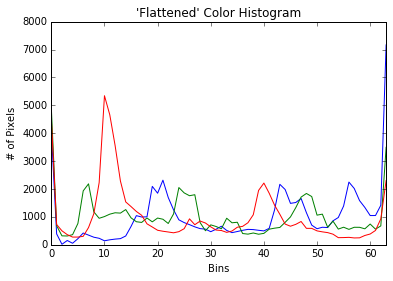

flattened feature vector size: 192


In [20]:
### Color histogram

# Load image
img = mpimg.imread('img.jpg')
imgplot = plt.imshow(img)
plt.show()

# grab the image channels, initialize the tuple of colors,
# the figure and the flattened feature vector
chans = cv2.split(img)
colors = ("b", "g", "r")
plt.figure()
plt.title("'Flattened' Color Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
features = []
 
# loop over the image channels
bins = 64
for (chan, color) in zip(chans, colors):
    # create a histogram for the current channel and
    # concatenate the resulting histograms for each
    # channel
    hist = cv2.calcHist([chan], [0], None, [bins], [0, 256])
    features.extend(hist)

    # plot the histogram
    plt.plot(hist, color = color)
    plt.xlim([0, bins-1])
    
plt.show()

 
# here we are simply showing the dimensionality of the
# flattened color histogram 256 bins for each channel
# x 3 channels = 768 total values -- in practice, we would
# normally not use 256 bins for each channel, a choice
# between 32-96 bins are normally used, but this tends
# to be application dependent
print "flattened feature vector size: %d" % (np.array(features).flatten().shape)

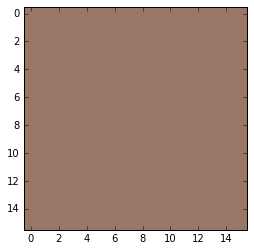

In [88]:
### Average color
from PIL import Image

def average_image_color(filename):
    i = Image.open(filename)
    h = i.histogram()

    # split into red, green, blue
    r = h[0:256]
    g = h[256:256*2]
    b = h[256*2: 256*3]

    # perform the weighted average of each channel:
    # the *index* is the channel value, and the *value* is its weight
    return (
        sum( i*w for i, w in enumerate(r) ) / sum(r),
        sum( i*w for i, w in enumerate(g) ) / sum(g),
        sum( i*w for i, w in enumerate(b) ) / sum(b)
    )

def get_col_block(col, s=64):
    # s doesn't actually work in controlling how it's displayed inline
    block = np.zeros([s, s, 3], 'uint8')
    block[:,:,0] = np.ones([s, s]) * col[0]
    block[:,:,1] = np.ones([s, s]) * col[1]
    block[:,:,2] = np.ones([s, s]) * col[2]
    return block

avg_col = average_image_color('img.jpg')
avg_col_block = get_col_block(avg_col, s=16)
plt.imshow(avg_col_block)
plt.show()



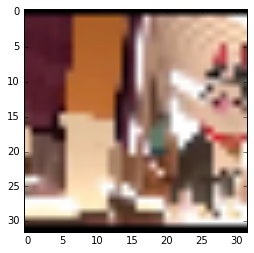

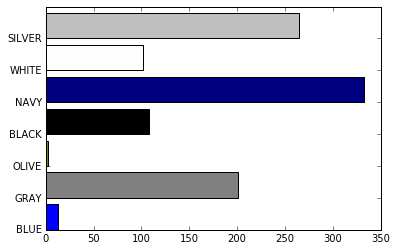

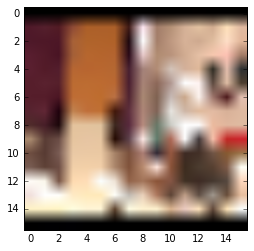

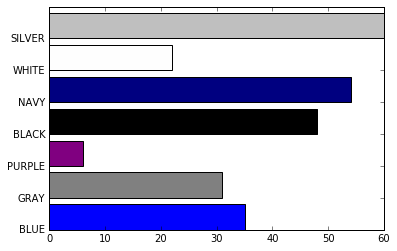

In [128]:
### Main color(s)

# Algorithm:
# Define a set of N colors
# For each pixel in image, find which of N colors it is closest to - bump counter of that color
# Use RGBdist from Nvidia Wetbrush paper?

# Set of N colors - resources:
# http://www.december.com/html/spec/color16codes.html - 16 named colors
# https://en.wikipedia.org/wiki/List_of_monochrome_and_RGB_palettes
# http://www.rapidtables.com/web/color/RGB_Color.htm - 16 named colors appears here again

from collections import defaultdict
import numpy as np

NAMED_COLORS = {'BLACK': (0,0,0),
               'WHITE': (255,255,255),
               'RED': (255,0,0),
               'LIME': (0,255,0),
               'BLUE': (0,0,255),
               'YELLOW': (255,255,0),
               'AQUA': (0,255,255),
               'MAGENTA': (255,0,255),
               'SILVER': (192,192,192),
               'GRAY': (128,128,128),
               'MAROON': (128,0,0),
               'OLIVE': (128,128,0),
               'GREEN': (0,128,0),
               'PURPLE': (128,0,128),
               'TEAL': (0,128,128),
               'NAVY': (0,0,128)
                }
NAMED_COLORS_RGB = NAMED_COLORS.values()

from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000

# color1_rgb = sRGBColor(1.0, 0.0, 0.0)
# color2_rgb = sRGBColor(0.0, 0.0, 1.0)
# color1_lab = convert_color(color1_rgb, LabColor)
# color2_lab = convert_color(color2_rgb, LabColor)
# delta_e = delta_e_cie2000(color1_lab, color2_lab)

def color_dist(rgb1, rgb2, method='euclidean'):
    if method =='euclidean':
        dist = np.sqrt(np.sum((np.array(rgb1) - np.array(rgb2)) ** 2))
    elif method =='delta-e':
        # Instead of range being [0,256], range in [0, 1.0]
        rgb1 = list(np.array(rgb1) / 256.0)
        rgb2 = list(np.array(rgb2) / 256.0)
        rgb1 = sRGBColor(rgb1[0], rgb1[1], rgb1[2])
        rgb2 = sRGBColor(rgb2[0], rgb2[1], rgb2[2])
        lab1 = convert_color(rgb1, LabColor)
        lab2 = convert_color(rgb2, LabColor)
        delta_e = delta_e_cie2000(lab1, lab2)
        dist = delta_e

    return dist

def get_main_colors_hist(img, dist_metric='euclidean'):
    b_chan, g_chan ,r_chan = cv2.split(img)
    hist = defaultdict(int)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            r, g, b = r_chan[i][j], r_chan[i][j], b_chan[i][j]
            # For current pixel, find closest color
            closest_dist = float('inf')
            closest_color_name = None
            for name, c in NAMED_COLORS.items():
                dist = color_dist([r,g,b], c, method=dist_metric)
                if dist < closest_dist:
                    closest_dist = dist
                    closest_color_name = name
            hist[closest_color_name] += 1

    return hist

def resize_img(img, r=0.25):
    resized = cv2.resize(img,None,fx=r, fy=r, interpolation = cv2.INTER_CUBIC)
    return resized

def plot_main_colors_hist(hist):
    fig, ax = plt.subplots()

    names, counts = zip(*hist.items())
    plot_colors = [tuple(np.array(NAMED_COLORS[name]) / 256.0) for name in names]
    ax.barh(range(len(names)), counts, color=plot_colors)

    ax.set_yticks(range(len(names)))
    ax.set_yticklabels(names)
    plt.show()

# Load image
img = mpimg.imread('img.jpg')
# img = mpimg.imread('/Users/eric/Movies/films/animated/Frozen (2013)/frames/frame_1073_0h17m53s.jpg')

resized = resize_img(img, r=1.0/8)
main_colors_hist = get_main_colors_hist(resized, dist_metric='euclidean')
plt.imshow(resized)
plot_main_colors_hist(main_colors_hist)

resized = resize_img(img, r=1.0/16)
main_colors_hist = get_main_colors_hist(resized, dist_metric='delta-e')
plt.imshow(resized)
plot_main_colors_hist(main_colors_hist)